# Statoil/C-CORE Iceberg Classifier Challenge

Identifies if a remotely sensed target is a ship or iceberg.

## Project: Build a Iceberg Classifier using Deep Learning

[Kaggle Statoil Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)


In [1]:
import pandas as pd 
import numpy as np 
import cv2 # Used to manipulated the images 
np.random.seed(1337) # The seed I used - pick your own or comment out for a random seed. A constant seed allows for better comparisons though

# Import Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Cropping2D
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
df_test = pd.read_json('../data/test.json')
df_test.inc_angle = df_test.inc_angle.replace('na',0)

In [3]:
df_train = pd.read_json('../data/train.json') # this is a dataframe

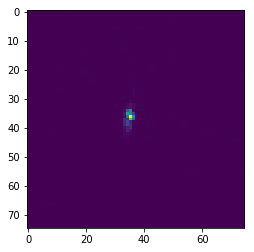

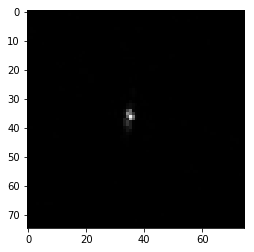

In [85]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np

img = []
band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_1"]])
band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_2"]])

img.append(np.dstack((a, b, c)))

def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

band_1_linear = decibel_to_linear(band_1)
band_2_linear = decibel_to_linear(band_2)
is_iceberg = np.array(df_train['is_iceberg'])
inc_angle = np.array(df_train['inc_angle'])


plt.imshow(band_1_linear[0])
plt.show()
cimg = cv2.cvtColor(band_1_linear[0], cv2.COLOR_GRAY2BGR)

plt.imshow(cimg)
plt.show()
fimg = cv2.flip(band_1_linear[0], 1)


#print(band_1[0].shape)
#plt.imshow(band_1[0])
#plt.show()
#plt.imshow(band_2[0])
#plt.show()
#print(band_2[0].shape)


In [86]:
from sklearn.model_selection import train_test_split    # split train test data
samples = list(zip(band_1_linear,band_2_linear, inc_angle, is_iceberg))
train_samples, valid_samples = train_test_split(samples, test_size=0.2)

In [87]:
print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(valid_samples)))

Train samples: 1283
Validation samples: 321


In [160]:
from scipy.ndimage.filters import uniform_filter

windows = [2, 4, 8] # can be tuple too if not symetric
noise_var = np.array([1, 2, 4])
noise_var_1 = np.round(np.var(band_1_linear)*noise_var,10)
noise_var_2 = np.round(np.var(band_2_linear)*noise_var,10)
# implement the Lee Filter for a band in an image already reshaped into the proper dimensions
def lee_filter(band, window, var_noise = 0.25):
        # band: SAR data to be despeckled (already reshaped into image dimensions)
        # window: descpeckling filter window (tuple)
        # default noise variance = 0.25
        # assumes noise mean = 0
    
        mean_window = uniform_filter(band, window)
        mean_sqr_window = uniform_filter(band**2, window)
        var_window = mean_sqr_window - mean_window**2

        weights = var_window / (var_window + var_noise)
        band_filtered = mean_window + weights*(band - mean_window)
        return band_filtered

In [161]:
import cv2               #for image read, flip, crop etc
import csv               #for csv file operation
import numpy as np       #for numpy array operation
import os                #for directory operation
import sklearn			 #for yield, util etc
from sklearn.model_selection import train_test_split    # split train test data

#for model
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout
from keras.layers.pooling import MaxPooling2D

def generator(samples, batch_size=32):
    """
    @description:      generates required images and measurement 
                       using sample(training/validation) in batches of batch size
    @param samples:    list of pairs containing imagePath and measuremnet
    @param batch_size: batch size to generate data, default is 32 
    """
    num_samples = len(samples)
    while 1: # Loops forever, generator never ends
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            is_icebergs = []
            for band_1_linear,band_2_linear, inc_angle, is_iceberg in batch_samples:
        
                band_1 = lee_filter(band_1_linear, windows[2], noise_var_1[2])
                band_2 = lee_filter(band_2_linear, windows[2], noise_var_2[2])
                band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
                # Rescale
                a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
                b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
                c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

                images.append(np.dstack((a, b, c)))
        
                is_icebergs.append(is_iceberg)
                
            # Data augment: trim image to only see section with road
            inputs = np.array(images)
            outputs = np.array(is_icebergs)
            yield sklearn.utils.shuffle(inputs, outputs)


In [162]:
train_generator = generator(train_samples, batch_size=32)
valid_generator = generator(valid_samples, batch_size=32)

In [173]:
def getNvidiaModel():
    """
    @description: NVIDIA CNN model for keras 2
    """
    #Build keras model
    
    model=Sequential()
    
    # CNN 1
    model.add(Conv2D(64, kernel_size=(5, 5),activation='relu', input_shape=(75, 75, 3)))
    #model.add(Cropping2D(cropping=((45,45), (0,0))))
    #model.add(BatchNormalization(axis =-1,epsilon=0.02,momentum=0.97))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.5))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(5, 5), activation='relu' ))
    model.add(BatchNormalization(axis =-1,epsilon=0.02,momentum=0.97))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    #CNN 4
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # You must flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output 
    model.add(Dense(1, activation="sigmoid"))
    #model.add(Dense(1, activation="softmax"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [177]:
# Creating Model
model = getNvidiaModel()

# Compiling and training the model
#model.compile(loss='mse', optimizer='adam')
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 71, 71, 64)        4864      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 31, 31, 128)       204928    
_________________________________________________________________
batch_normalization_22 (Batc (None, 31, 31, 128)       512       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 15, 15, 128)       0         
__________

In [178]:
import sklearn

batch_size = 32
epochs = 25

steps_per_epoch = len(train_samples)/batch_size
valid_steps = len(valid_samples)/batch_size
history = model.fit_generator(train_generator, steps_per_epoch= \
                 steps_per_epoch , validation_data=valid_generator, \
                 validation_steps=valid_steps, epochs=epochs, verbose=1)
model.save('model.h5')

Epoch 1/25
41/40 [==============================] - 99s 2s/step - loss: 0.6872 - acc: 0.5871 - val_loss: 0.6417 - val_acc: 0.6791
Epoch 2/25
41/40 [==============================] - 97s 2s/step - loss: 0.5239 - acc: 0.7195 - val_loss: 0.5112 - val_acc: 0.7477
Epoch 3/25
41/40 [==============================] - 97s 2s/step - loss: 0.4868 - acc: 0.7514 - val_loss: 0.6797 - val_acc: 0.5981
Epoch 4/25
41/40 [==============================] - 94s 2s/step - loss: 0.4571 - acc: 0.7770 - val_loss: 0.3807 - val_acc: 0.8037
Epoch 5/25
41/40 [==============================] - 90s 2s/step - loss: 0.3695 - acc: 0.8372 - val_loss: 0.4121 - val_acc: 0.8131
Epoch 6/25
41/40 [==============================] - 98s 2s/step - loss: 0.3997 - acc: 0.8193 - val_loss: 0.4826 - val_acc: 0.7477
Epoch 7/25
41/40 [==============================] - 97s 2s/step - loss: 0.3943 - acc: 0.8182 - val_loss: 0.3799 - val_acc: 0.8006
Epoch 8/25
41/40 [==============================] - 94s 2s/step - loss: 0.3694 - acc: 0.83

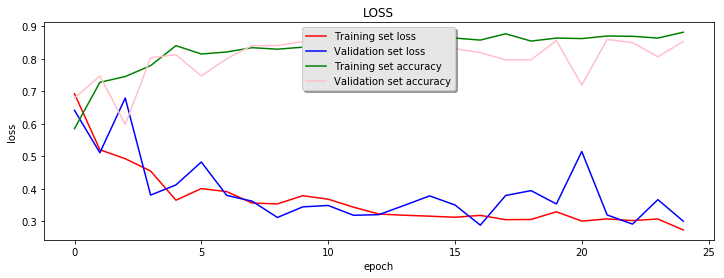

In [179]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(history.history['loss'], color='red', label='Training set loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation set loss')
plt.plot(history.history['acc'], color='green', label='Training set accuracy')
plt.plot(history.history['val_acc'], color='pink', label='Validation set accuracy')
plt.title('LOSS')
plt.ylabel('loss')
plt.xlabel('epoch')
legend = ax.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')